ECSE 415 : Assignment 3

READ ME : Please change the path variable to the drive location containing the Color FERET database ,and  the Schitt's Creek photo 

Numpy , matplotlib , cv2 , sklearn for splitting testing and training data ,classification and accuracy calculations


In [ ]:
# Initial setup 

from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import glob, os, errno
import os

#used to split training data
from sklearn.model_selection import train_test_split

#Used to generate data for the histogram 
import random

drive.mount('/content/drive')


#Linking to the image database in my personal drive
path = '/content/drive/MyDrive/ECSE 415/Assignment_3/newdata/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data

## Convert all images to grayscale and down-sample by a scale of 4

In [ ]:
#Source inspiration : https://stackoverflow.com/questions/55103420/how-to-split-datasets-into-training-and-test-data-with-sklearn
#Data for scaling

#Input 
path_to_data = path + 'Color_FERET_Database/'

width = int(512 * 0.25)
height = int(768 * 0.25)
dimensions = (width, height)


#Creating a new directory to store the modified images 
images = []
subject = []
folders = os.listdir(path_to_data)
print(len(folders))
# loading data to lists
for folder in folders:
    for file in os.listdir(path_to_data + folder + '//'):
        img = cv2.imread(path_to_data + folder + '//' + file)
        if img is not None:
          gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
          scale = cv2.resize(gray, dimensions, interpolation = cv2.INTER_AREA)
          images.append(scale)
          subject.append(folder[2:])



52


## Training and testing sets

In [ ]:
#Source inspiration : https://stackoverflow.com/questions/55103420/how-to-split-datasets-into-training-and-test-data-with-sklearn

# using train test split to train images based on their subject with a random state of 10 

train_images, test_images, train_subject, test_subject = train_test_split(np.asarray(images), subject, test_size=0.2, random_state=10)


## Histogram


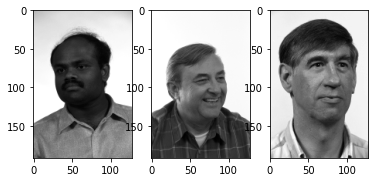

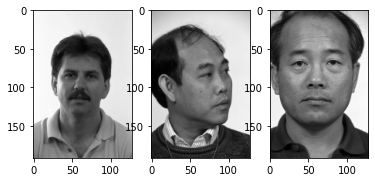

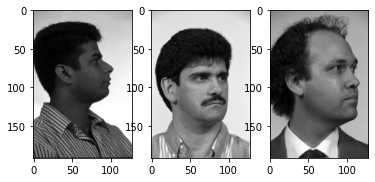

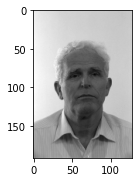

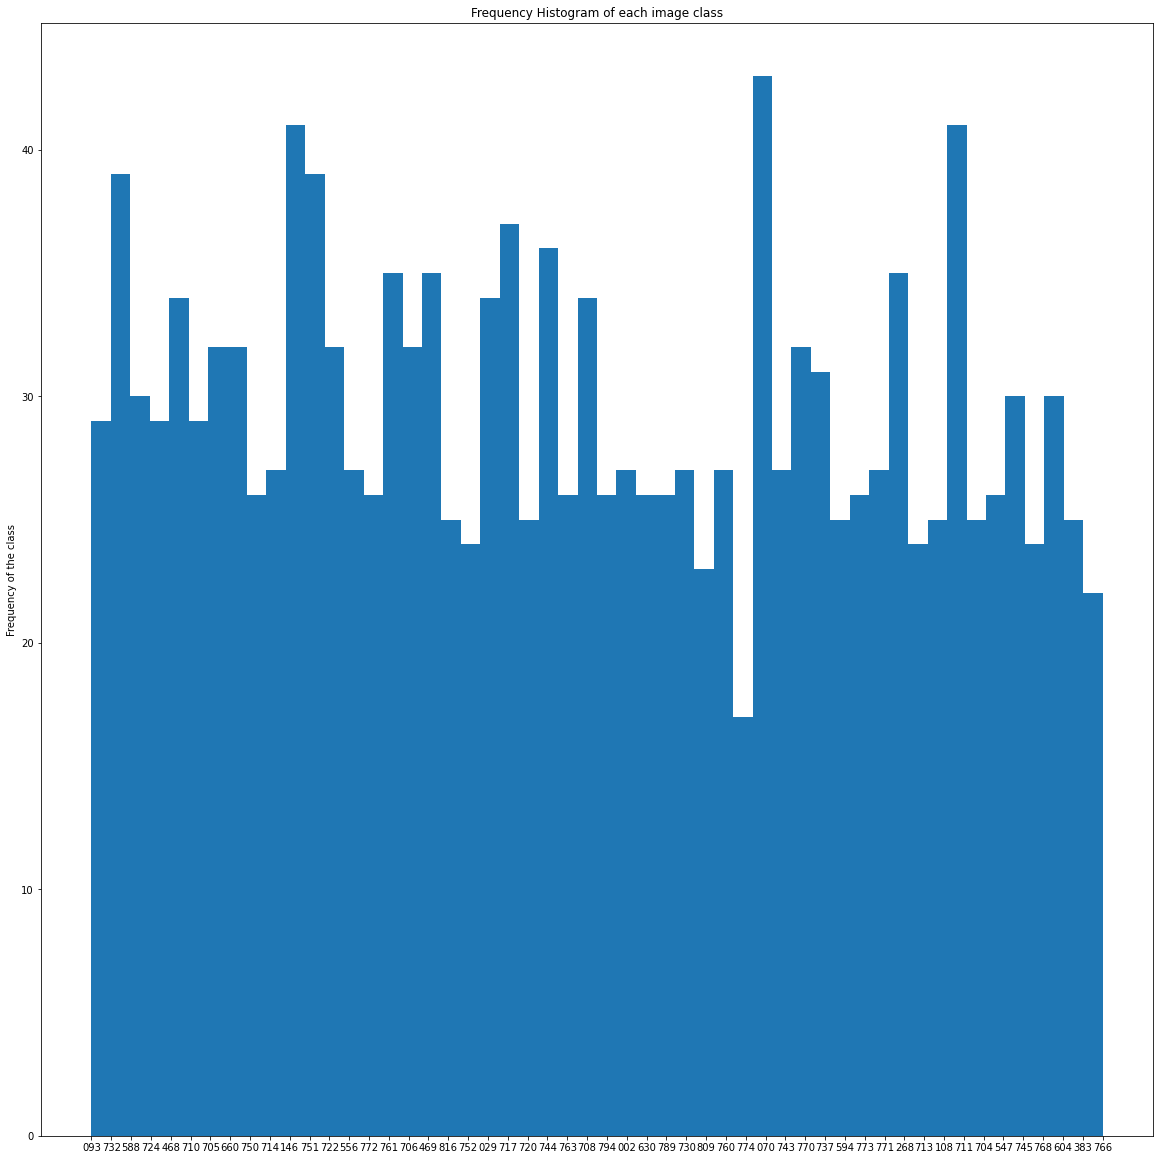

In [ ]:
#1. Select 10 random images from the dataset, display them and return their index
subjectIndexes = []
for i in range (10) : 
  random_index = random.randrange(len(train_images))
  subjectIndexes.append(random_index)


plt.subplot(131), plt.imshow(train_images[subjectIndexes[0]], cmap="gray")
plt.subplot(132), plt.imshow(train_images[subjectIndexes[1]], cmap="gray")
plt.subplot(133), plt.imshow(train_images[subjectIndexes[2]], cmap="gray")
plt.show()


plt.subplot(131), plt.imshow(train_images[subjectIndexes[3]], cmap="gray")
plt.subplot(132), plt.imshow(train_images[subjectIndexes[4]], cmap="gray")
plt.subplot(133), plt.imshow(train_images[subjectIndexes[5]], cmap="gray")
plt.show()

plt.subplot(131), plt.imshow(train_images[subjectIndexes[6]], cmap="gray")
plt.subplot(132), plt.imshow(train_images[subjectIndexes[7]], cmap="gray")
plt.subplot(133), plt.imshow(train_images[subjectIndexes[8]], cmap="gray")
plt.show()

plt.subplot(131), plt.imshow(train_images[subjectIndexes[9]], cmap="gray")
plt.show()


#Create a histogram of the frequency of each subject 
plt.figure(figsize=(16, 16), constrained_layout=True)
plt.hist(train_subject, bins=52)
plt.gca().set(title='Frequency Histogram of each image class', ylabel='Frequency of the class');

# 2. Eigenface representation

## Implement PCA

In [ ]:
#1. Storing the data into a matrix 


init = False

for img in train_images:
  matrix = img.reshape(192*128,1)
  if not init:
    A = matrix
    init = True
    continue
  else:
    A = np.c_[ A, matrix ]


In [ ]:
#2. PCA calculation Source inspiration : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

from numpy import mean
from numpy import cov
import numpy.linalg as LA
from numpy.linalg import eig

M = mean(A, axis = 1)
M = M.reshape(A.shape[0], 1)


normalized = A - M

# get covariance
V = cov(normalized.T)

eigenvalues, eigenvectors = eig(V)


index = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[index]
eigenvectors = eigenvectors[:,index]


## Plot the total variance against the number of eigenvectors

In [ ]:
#Getting the value of the variance
variance = []
sumeigen = np.sum(eigenvalues)
for i , d in enumerate(eigenvalues):
  variance.append(np.sum(eigenvalues[:i])/sumeigen)


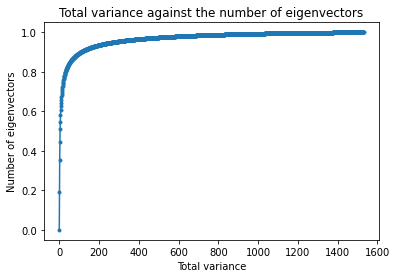

In [ ]:
#Plot fraction of the total variance against the number of eigenvectors

plt.figure()
plt.plot(variance, '.-')
plt.title("Total variance against the number of eigenvectors")
plt.xlabel("Total variance")
plt.ylabel("Number of eigenvectors")
plt.show()

##Plot the normalized variance against the eigenvector index

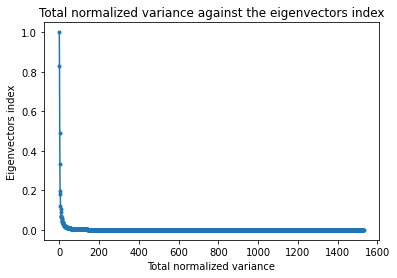

In [ ]:
plt.figure()
plt.plot(eigenvalues/eigenvalues.max(), '.-')
plt.title("Total normalized variance against the eigenvectors index")
plt.xlabel("Total normalized variance")
plt.ylabel("Eigenvectors index")
plt.show()

##Do we need all the vectors to represent the data? 

No, we do not need all the vectors to represent the data , as we can see in the plots previously created , the variance reaches a plateau at around 150. Including all the following vectors would be very computationally expensive and could lead to overfitting and skew future predictions, so I'll only be working with the first 150 vectors. 

##Display the first 5 eigenfaces

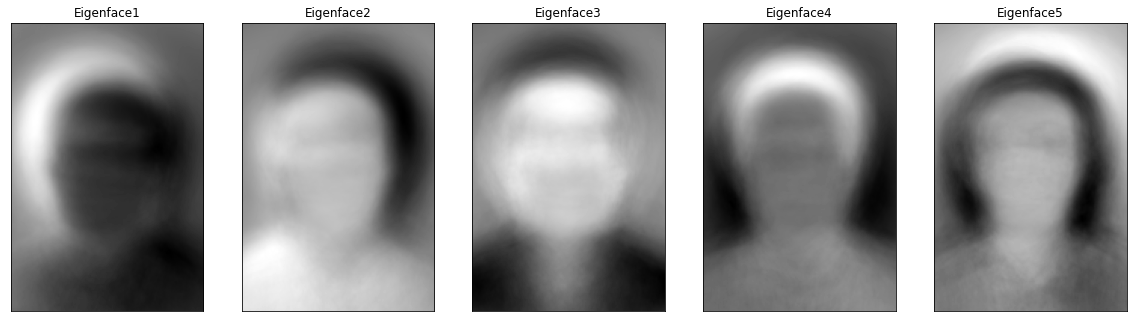

In [ ]:

plt.figure(figsize=(20,20))
#Picking the first 250 eigenvectors 
eigenvectors = eigenvectors[:,:150]

#Getting the dot product of the vectors & matrix 
eigenfaces = np.dot(A,eigenvectors)

for i in range (eigenfaces.shape[1]):
  eigenfaces[:,i] /= LA.norm( eigenfaces[:,i])
 


#Display faces
for i in range(5):
    img = eigenfaces[:,i].reshape(192,128)
    plt.subplot(1,5,1+i)
    plt.title("Eigenface{}".format(i+1)), plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()



# Classifier

##L2 distance

In [ ]:
#Finding the nearest neighbor (L2 distance) for every testing image Source : https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
def CalculateAccuracy(images_train, images_test,subject_train , subject_test): 
  good_fit = 0
  idx = 0
  train_shape =images_train.shape[1]
  test_shape =images_test.shape[1]
  for i in range(test_shape):
     #Calculate the L2 distance
    distance = float('inf')
    for j in range(train_shape):
      L2 = np.linalg.norm(images_train[:,j]-images_test[:,i])
      if (L2<distance):
        distance = L2
        idx = j
    #Check whether both images belong to the same person 
    if (subject_train[idx]==subject_test[i]):
      good_fit += 1

#Fraction of test images that have a same-person neighbor

  accuracy = good_fit*100/test_shape
  return accuracy

In [ ]:
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



#Accuracy in high dimensional pixel space
D= np.ndarray(shape=(192*128,test_images.shape[0]))

#flattening the test images
for i, img in enumerate(test_images):
  D[:,i] = test_images[i].flatten()

high_dimension = CalculateAccuracy(A, D, train_subject, test_subject )
print("Accuracy in the high dimensional pixel space" , high_dimension, "%")

#Accuracy in the eigenspace

#transpose to the eigenspace
transpose_train = np.dot(eigenfaces.transpose(), A)
transpose_test = np.dot(eigenfaces.transpose(),D)

eigenspace = CalculateAccuracy(transpose_train , transpose_test , train_subject , test_subject)

print("Accuracy in the eigenspace" , eigenspace, "%")



Accuracy in the high dimensional pixel space 71.61458333333333 %
Accuracy in the eigenspace 71.875 %


##Difference between the high dimensional pixel space and eigenspace

The classification accuracy for eigenspace and high dimensional pixel is quite close , with a difference of around 0.2% . This makes sense because the PCA algorithm's goal is to transform a large dataset into a smaller one that still contains most of the information , so it's normal for the eigenspace to have similar accuracy from the high dimensional pixel space. 



In [ ]:
#SVM classifier in the eigenspace Source : https://medium.com/analytics-vidhya/implementing-svm-for-performing-classification-and-finding-accuracy-in-python-using-datasets-wine-e4fef8e804b4

from sklearn import svm

from sklearn.metrics import accuracy_score


sv = svm.LinearSVC(C=0.1,max_iter=1000000)
#Fitting the Linear SVM before using it 
fitting = sv.fit(transpose_train.transpose(), train_subject)
prediction = sv.predict(transpose_test.transpose())
accuracy = accuracy_score(test_subject,prediction)*100


print("SVM classifier accuracy" , accuracy, "%")

SVM classifier accuracy 54.947916666666664 %


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


##Comparing the accuracy of this classifier with the nearest neighbour classifier

The SVM classifier is a little less accurate than the nearest neighbor , this means that our dataset is much larger thant the amount of features that we were using.

# Face detection

##Detection using PCA

In [ ]:
##Inputting the image 
newpic = mpimg.imread(path+'Schitts_Creek_group.jpeg')

In [ ]:
#Source inspiration : https://medium.com/@reubenrochesingh/building-face-detector-using-principal-component-analysis-pca-from-scratch-in-python-1e57369b8fc5
def scanning(win):
  weights = (normalized.T).dot(eigenfaces)
  newshape = win.reshape(win.shape[0]*win.shape[1], -1)
  n_vector = newshape - M
  single_weight = (n_vector.T).dot(eigenfaces)
  difference = weights - single_weight
  norms = np.linalg.norm(difference, axis=1)
  idx = np.argmin(norms)
  return norms[idx]

Faces detected 13


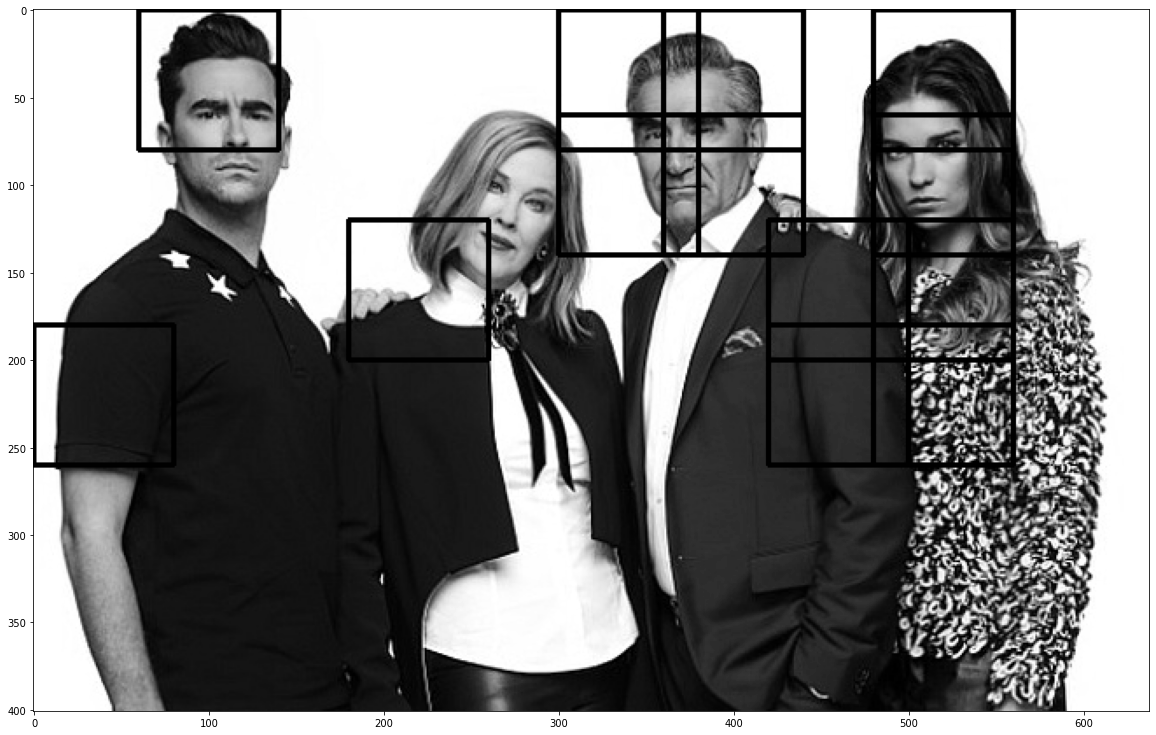

In [ ]:
#Source inspiration : https://medium.com/@reubenrochesingh/building-face-detector-using-principal-component-analysis-pca-from-scratch-in-python-1e57369b8fc5
img = newpic.copy()
image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h,w = image_gray.shape

window_h = 192
window_w = 128
step = 60
faces = 0; 

threshold1 = 9000
threshold2  = 6500
threshold = 7500
for i in range(0,h-window_h,step):
  for j in range(0, w-window_w,step):
    window = image_gray[i:i+window_h,j:j+window_w]
    window = cv2.resize(window,(192,128)).flatten().reshape(A.shape[0],1)
    scan = scanning(window)
    if scan< threshold:
      image_gray = cv2.rectangle(image_gray, (j, i), (j + 80, i + 80), (0, 0, 255), 2)
      faces+=1 
print("Faces detected", faces)    
plt.figure(figsize=(20,20))
plt.imshow(image_gray , cmap="gray")
plt.show()


##Detection with the Viola-Jones face detector

In [ ]:
##Inputting the image 
schitts_creek_viola = mpimg.imread(path+'Schitts_Creek_group.jpeg')


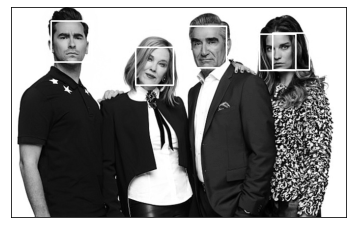

In [ ]:
##Source : ECSE 415 Winter 2021 Tutorial 5 

#The haarcascade default xml file is being used for this algorithm and can be found in tutorial 5

cascade_path = path + 'haarcascade_frontalface_default.xml'

face_cascade = cv2.CascadeClassifier(cascade_path)

gray = cv2.cvtColor(schitts_creek_viola, cv2.COLOR_BGR2GRAY)

# detecMutliScale
#   Params: image – Matrix of the type CV_8U containing an image where objects are detected.
#           scaleFactor (1.1) – Parameter specifying how much the image size is reduced at each image scale.
#           minNeighbors (3) – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
#           minSize (0,0) – Minimum possible object size. Objects smaller than that are ignored.
#           maxSize (0,0) – Maximum possible object size. Objects larger than that are ignored.

faces = face_cascade.detectMultiScale(gray, 1.1, 2)

for (x,y,w,h) in faces:
    gray = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(gray, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()


##Comparison between Viola-Jones and PCA face detection

The Viola-Jones face detection algorithm performed much better than the PCA face detection algorithm. Indeed , it's easy to see that Viola-Jones , finds all four faces , generating 0 false positives , and 0 false negatives. 

The PCA algorithm on the other hand detected 13 faces instead of the 4 expected. Three of them were close to being true positives (partly bounding a face) , and nine of them were false positives. The second character from the left only has a quarter of her face detected so it will be considered a false negative. 

Viola-Jones also scaled the bounding boxes around the faces a lot tighter , leaving no empty borders around them , because it can scan through varying window sizes. 

Finally , we can expect the Viola-Jones detector to perform when PCA does not is when the faces need quite different window sizes to be properly bounded and when the faces are very different from the training eigenfaces. 